In [79]:
#pip install pandas numpy matplotlib prophet scikit-learn joblib

In [80]:
  from google.colab import files

  uploaded = files.upload()

Saving BREAD_BAKERY.csv to BREAD_BAKERY.csv


In [81]:
import pandas as pd
import os

In [82]:
trends_data = pd.read_csv('Category9-dataset.csv')

In [83]:
holidays = pd.read_csv('holidays.csv')

In [84]:
holidays.head()

,date,type,locale,locale_name,description,transferred
0,2012-03-02,Holiday,Local,Manta,Fundacion de Manta,False
1,2012-04-01,Holiday,Regional,Cotopaxi,Provincializacion de Cotopaxi,False
2,2012-04-12,Holiday,Local,Cuenca,Fundacion de Cuenca,False
3,2012-04-14,Holiday,Local,Libertad,Cantonizacion de Libertad,False
4,2012-04-21,Holiday,Local,Riobamba,Cantonizacion de Riobamba,False


In [85]:
df=trends_data

In [86]:
trends_data.head()

,date,sales
0,2019-01-01,180.58900
1,2019-01-02,26246.31900
2,2019-01-03,18456.48002
3,2019-01-04,16721.96901
4,2019-01-05,22367.76108


In [87]:
# Assuming your dataframe is called df
df = df.rename(columns={'date': 'ds', 'sales': 'y'})

# Convert 'ds' column to datetime
df['ds'] = pd.to_datetime(df['ds'])


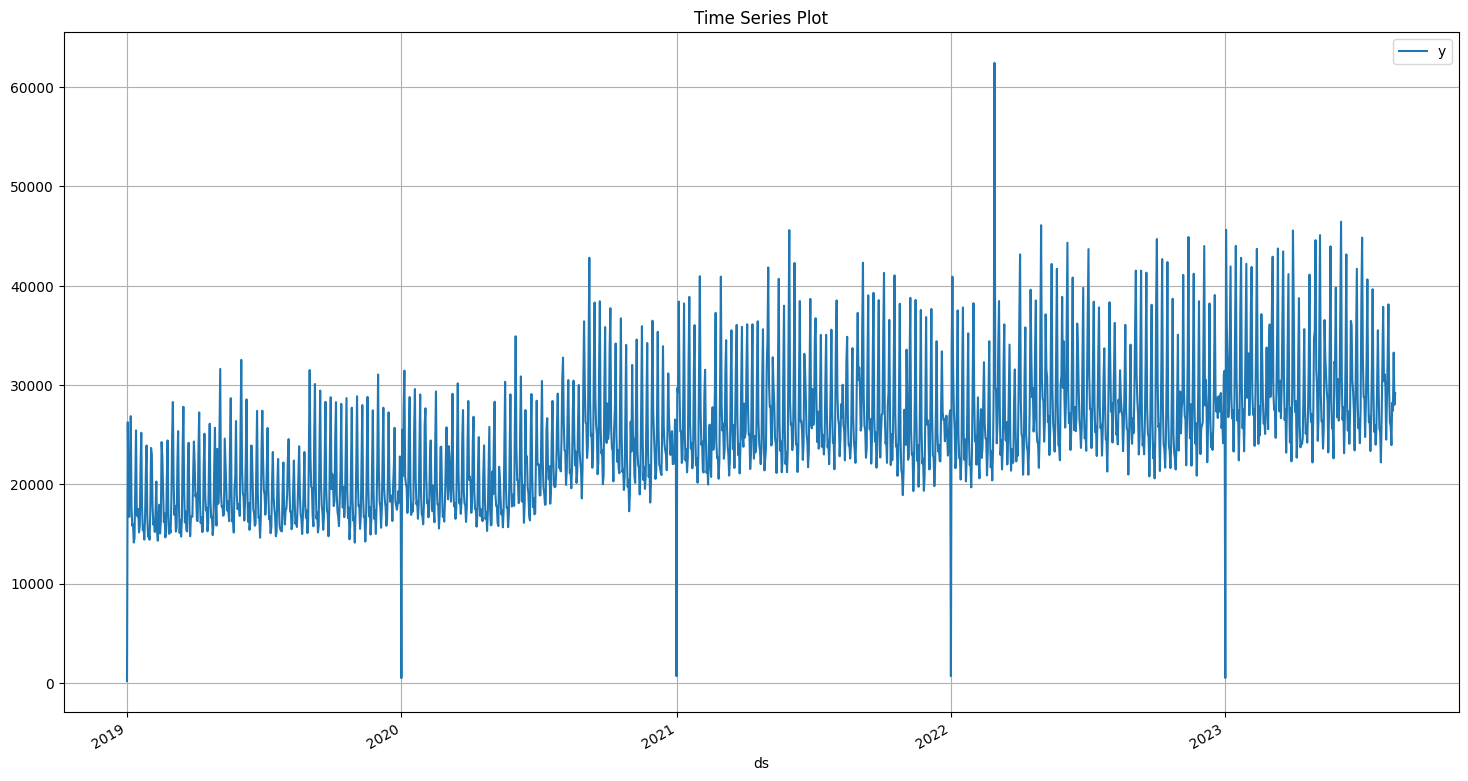

In [88]:
import matplotlib.pyplot as plt

df.plot(x='ds', y='y', title='Time Series Plot', figsize=(18, 10))
plt.grid(True)
plt.show()


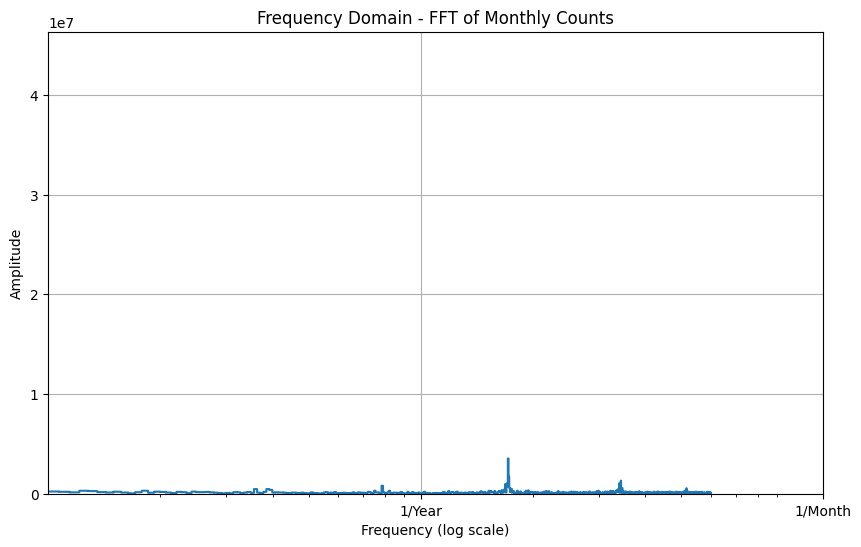

In [89]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

# Assuming 'df' has a datetime column 'ds' and a value column 'y' (e.g., 'Tops')
# You already renamed 'release_month' → 'ds' and 'Tops' → 'y'

# Convert to numpy array
y = df['y'].values

# Apply real FFT
fft = tf.signal.rfft(y)

# Frequencies for FFT
f_per_dataset = np.arange(0, len(fft))

# Since this is monthly data:
n_samples = len(df['y'])
months_per_year = 12
years_per_dataset = n_samples / months_per_year

# Calculate frequency in cycles per year
f_per_year = f_per_dataset / years_per_dataset

# Plot the FFT
plt.figure(figsize=(10, 6))
plt.step(f_per_year, np.abs(fft))
plt.xscale('log')
plt.ylim(0, max(np.abs(fft)) * 1.1)
plt.xlim([0.1, max(f_per_year)])
plt.xticks([1, 12], labels=['1/Year', '1/Month'])
plt.xlabel('Frequency (log scale)')
plt.ylabel('Amplitude')
plt.title('Frequency Domain - FFT of Monthly Counts')
plt.grid(True)
plt.show()


In [90]:
column_indices = {name: i for i, name in enumerate(df.columns)}

n = len(df)
train_df = df[0:int(n*0.8)]
test_df = df[int(n*0.8):]

num_features = df.shape[1]

In [91]:
# Your holidays dataframe (call it holidays_raw)
holidays_raw = holidays  # replace with your real DataFrame name

# Prepare for Prophet
holidays_prophet = holidays_raw[['date', 'description']].rename(columns={
    'date': 'ds',
    'description': 'holiday'
})

# Optional: Add lower_window and upper_window if you want
holidays_prophet['lower_window'] = 0
holidays_prophet['upper_window'] = 0


In [92]:
# Create 'is_weekend' column (1 if Saturday or Sunday, else 0)
train_df['is_weekend'] = train_df['ds'].dt.dayofweek.isin([5, 6]).astype(int)


<ipython-input-92-71b0051287fa>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df['is_weekend'] = train_df['ds'].dt.dayofweek.isin([5, 6]).astype(int)


In [93]:
test_df['is_weekend'] = test_df['ds'].dt.dayofweek.isin([5, 6]).astype(int)

<ipython-input-93-dea503d60e07>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df['is_weekend'] = test_df['ds'].dt.dayofweek.isin([5, 6]).astype(int)


In [94]:
train_df

,ds,y,is_weekend
0,2019-01-01,180.58900,0
1,2019-01-02,26246.31900,0
2,2019-01-03,18456.48002,0
3,2019-01-04,16721.96901,0
4,2019-01-05,22367.76108,1
...,...,...,...
1341,2022-09-07,26954.62397,0
1342,2022-09-08,22999.11098,0
1343,2022-09-09,24941.60800,0
1344,2022-09-10,33265.76600,1


In [95]:
train_df

,ds,y,is_weekend
0,2019-01-01,180.58900,0
1,2019-01-02,26246.31900,0
2,2019-01-03,18456.48002,0
3,2019-01-04,16721.96901,0
4,2019-01-05,22367.76108,1
...,...,...,...
1341,2022-09-07,26954.62397,0
1342,2022-09-08,22999.11098,0
1343,2022-09-09,24941.60800,0
1344,2022-09-10,33265.76600,1


In [96]:
from prophet import Prophet
model = Prophet(
    changepoint_prior_scale=0.09,
    seasonality_prior_scale=15,
    changepoint_range=0.95,
    yearly_seasonality=True,
    weekly_seasonality=True,
    daily_seasonality=False,
    holidays=holidays_prophet
)


#model.add_seasonality(name='monthly', period=30.5, fourier_order=5)
model.add_regressor('is_weekend')
# Quarterly seasonality (every ~3 months)
model.add_seasonality(name='quarterly', period=90, fourier_order=5)


model.fit(train_df)



DEBUG:cmdstanpy:input tempfile: /tmp/tmpub9qd4w_/aknrya5d.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpub9qd4w_/dama1eex.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=77744', 'data', 'file=/tmp/tmpub9qd4w_/aknrya5d.json', 'init=/tmp/tmpub9qd4w_/dama1eex.json', 'output', 'file=/tmp/tmpub9qd4w_/prophet_modelq_2fxdxu/prophet_model-20250503041240.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
04:12:40 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
04:12:40 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


In [97]:
test_df['ds'].isnull().sum()

np.int64(0)

In [98]:
test_df

,ds,y,is_weekend
1346,2022-09-12,27456.29800,0
1347,2022-09-13,23919.48000,0
1348,2022-09-14,24365.96600,0
1349,2022-09-15,23018.50100,0
1350,2022-09-16,26289.00400,0
...,...,...,...
1678,2023-08-11,28204.48600,0
1679,2023-08-12,27403.54800,1
1680,2023-08-13,33262.75700,1
1681,2023-08-14,28002.45700,0


In [99]:
test_fcst = model.predict(test_df)

test_fcst['yhat'] = test_fcst['yhat'].clip(lower=0)
test_fcst['yhat_lower'] = test_fcst['yhat_lower'].clip(lower=0)
test_fcst['yhat_upper'] = test_fcst['yhat_upper'].clip(lower=0)
test_fcst['yhat'] = test_fcst['yhat'].round()

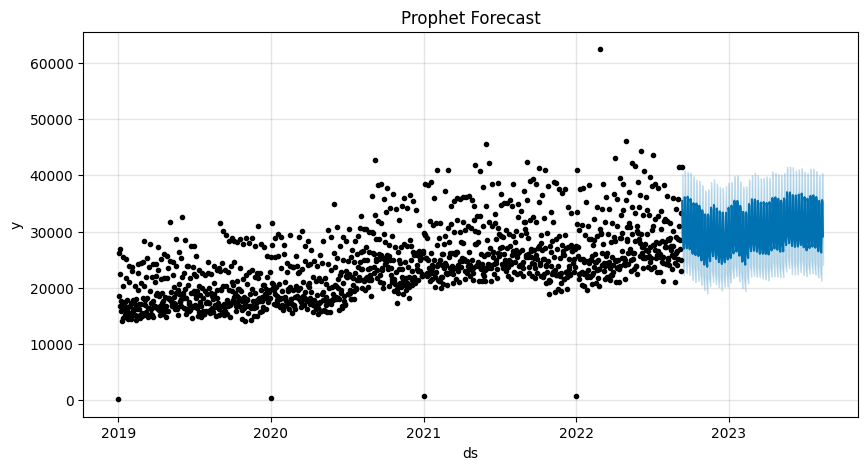

In [100]:


fig, ax = plt.subplots(figsize=(10, 5))
fig = model.plot(test_fcst, ax=ax)
ax.set_title('Prophet Forecast')
plt.show()



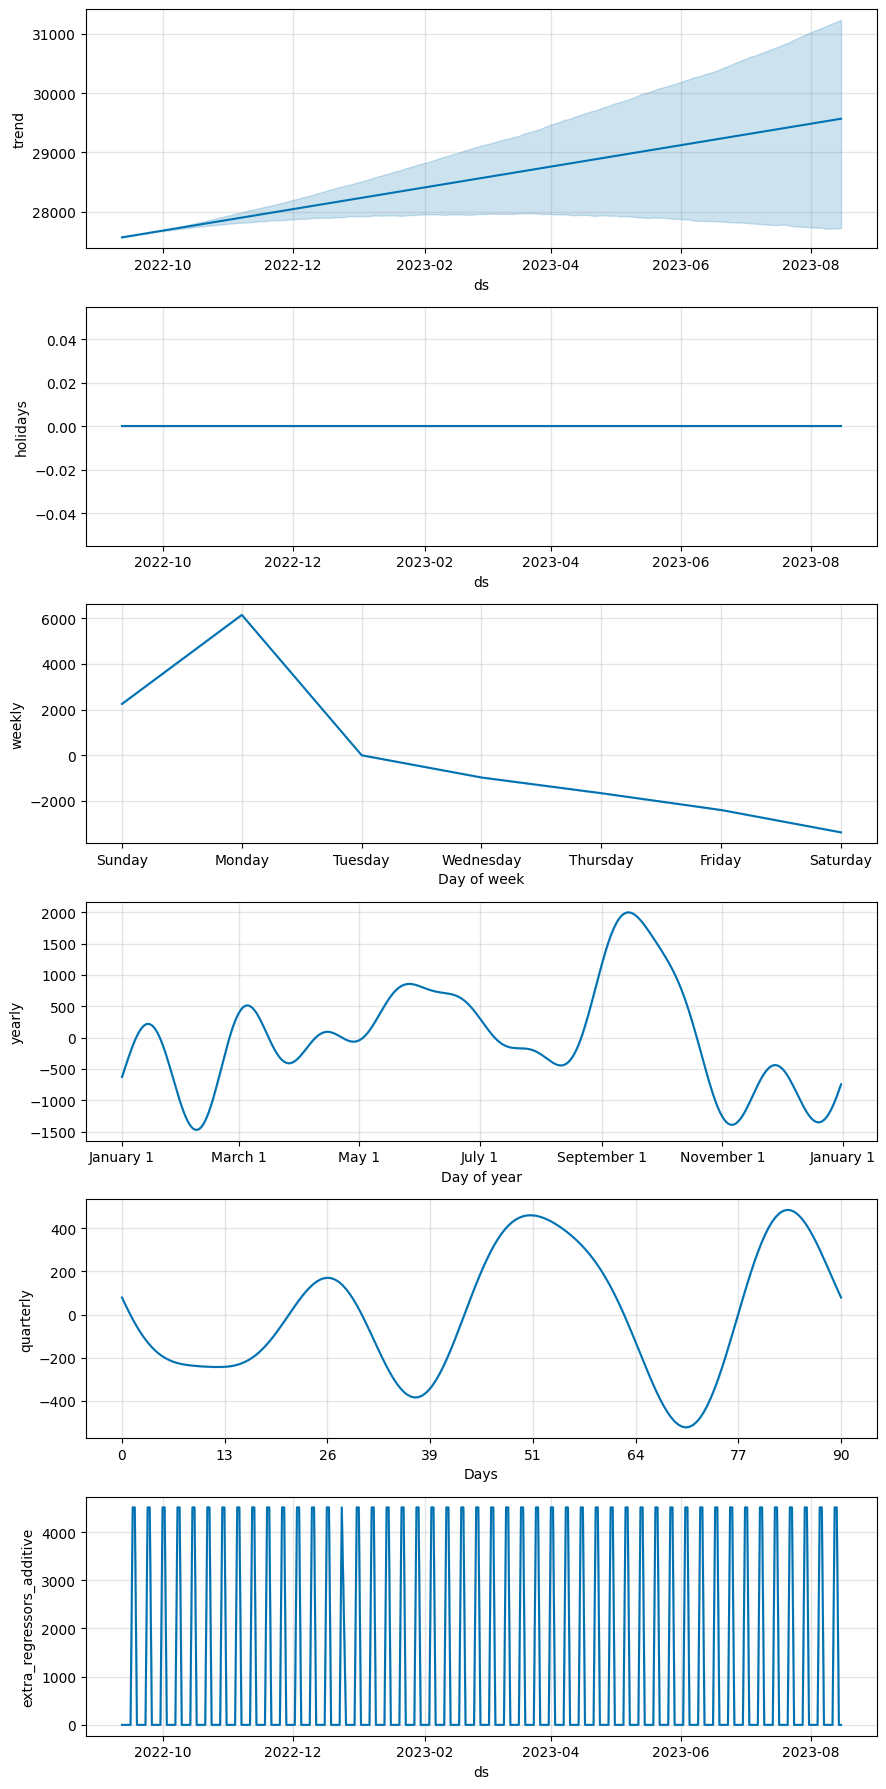

In [101]:

fig = model.plot_components(test_fcst)
plt.show()


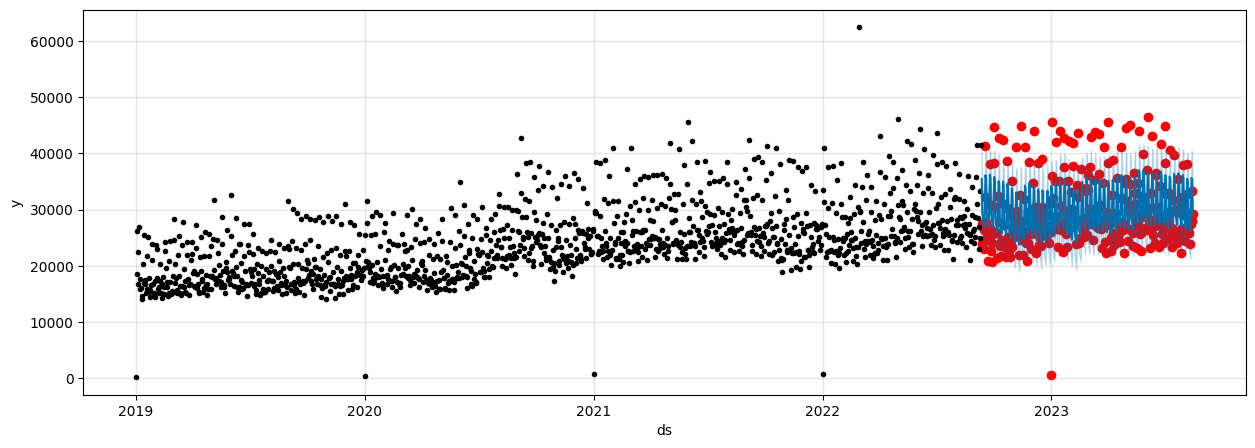

In [102]:


# Plot the forecast with the actuals
f, ax = plt.subplots(figsize=(15, 5))
ax.scatter(test_df['ds'], test_df['y'], color='r')
fig = model.plot(test_fcst, ax=ax)



In [103]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

# Align predictions with actuals
y_true = test_df['y'].values
y_pred = test_fcst['yhat'].values

# Evaluation Metrics
mae = mean_absolute_error(y_true, y_pred)
mse = mean_squared_error(y_true, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_true, y_pred)

print(f"MAE: {mae:.2f}")
print(f"MSE: {mse:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"R² Score: {r2:.2f}")


MAE: 3815.14
MSE: 24371386.53
RMSE: 4936.74
R² Score: 0.33
